## Import necessary python modules

In [1]:
import os
import napari
import tifffile
import numpy as np
import matplotlib.pyplot as plt

import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack

from copy import deepcopy
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel
from buildReferenceSpot import buildReferenceSpotFromImages
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ, reorderZstack

## Specify Input and Output folders, identifiers

In [2]:
homeFolder = '/media/raphael/data/works/full_data_movie/'
nameKey = 'c3_21_c3_45_ON_1_w1SPI-488_s'

imsQ = '3'
cellNumber = '5'
nucleiStackForm = nameKey+imsQ+"_cell_"

pathToTimeSequenceFullView = homeFolder+nameKey+imsQ+'/*.tif'
cell_Crop_Folder = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
pathToTimeSequenceCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'


sequenceCell = imr(pathToTimeSequenceCell)
mipSequenceCell = np.max(sequenceCell, axis=1)
MaxTimePoint = sequenceCell.shape[0]

## Specify voxel and object size

In [3]:
voxelRadius = (600, 110, 110) # in nanometers
objectRadius = (600, 105, 105) # in nanometers

In [4]:
# Save Maximum Intensity Projection of the cell movie

maxProjSavePath = homeFolder+nameKey+imsQ+'/'
with tifffile.TiffWriter(maxProjSavePath+'MAX_cell'+cellNumber+'.tif', imagej=True) as tif:
    tif.write(mipSequenceCell)

## Choose detection threshold

In [5]:
selectedThreshold = int(input("Enter your selected threshold: "))

Enter your selected threshold: 100


In [6]:
maxFrame = int(input("Enter your max Frame: "))
maxFrame = maxFrame + 1 

Enter your max Frame: 123


## Get a list of spots detected using the threshold specified in previous step

In [7]:
images=[]    
spots_list=[]

spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=voxelRadius, 
    object_radius_nm=objectRadius, 
    ndim=3)

for t in range(1,maxFrame,1):

    path = os.path.join(cell_Crop_Folder, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna = stack.read_image(path)
    images.append(rna)

n=len(images)
print("Total number of images : "+str(n))

for rna in images:
    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
    spots_list.append(spots_)


Total number of images : 123


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


In [22]:
threshold

12.0

## Build reference spot

image list found!
Found 13675
Found 13675 spots, max intensity = 309


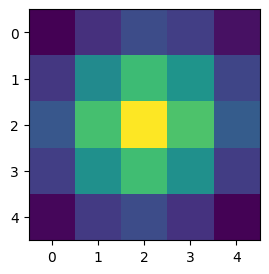

In [8]:
reference_spot = buildReferenceSpotFromImages(images, spots_list, alpha=0.5, gamma=5, voxelSize=voxelRadius, objectSize=objectRadius)
%matplotlib inline
plt.figure(num=3,figsize=(3,3))
plt.imshow(np.max(reference_spot, axis=0))
refSpot = deepcopy(reference_spot)

## Perform spot and cluster detection for all frames

In [9]:
spotsFrame, clustersFrames, ThresholdFrames = getSpotAndClusters(cell_Crop_Folder, 
                                                                 reference_spot, 
                                                                 cellnumber=cellNumber, 
                                                                 startTime=1,
                                                                 stopTime=maxFrame, 
                                                                 thresholdManual=selectedThreshold, 
                                                                 beta=3, 
                                                                 gamma=10,
                                                                 numberOfSpots=2,
                                                                 radiusCluster=700, 
                                                                 voxelSize=voxelRadius, 
                                                                 objectSize=objectRadius,
                                                                 extensionMov='.tif')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


122
123
done!


In [10]:
from alive_progress import alive_bar
import time
def order_clusters_frames(clustersFrames,mipSequenceCell,threshold ):

    res = []
    with alive_bar(len(clustersFrames), title = "order cluster frame",force_tty=True) as bar :
        for i in range(len(clustersFrames)):
            #print('clustersFrames', i)
            frame = clustersFrames[i]
            tmp =[]
            id = 0
            for j in range(len(frame)):
                y_coord = frame[j][1]
                x_coord = frame[j][2]

                test = np.array(mipSequenceCell[i][y_coord:y_coord+1,x_coord:x_coord+1])
                val = test[0][0]

                tmp.append(val)

            try :
                # possibilite de rajouter une condition 
                # pour filtrer les sites de transcription uniquement en rajoutant un threshold de 1000
                if max(tmp) < threshold :
                    res.append([np.zeros(5)])
                else :
                    index_max = tmp.index(max(tmp))
                    #print(max(tmp), index_max)
                    #print(frame)
                    res.append([frame[index_max]])

            except ValueError as e:
                res.append([np.zeros(5)])
            time.sleep(0.1)
            bar()
        
    
        return res 

In [11]:
a = order_clusters_frames(clustersFrames,mipSequenceCell,530)

order cluster frame |████████████████████████████████████████| 123/123 [100%] in


In [12]:
a

[[array([18, 82, 49, 23,  8])],
 [array([20, 66, 49, 29,  2])],
 [array([21, 64, 48, 36,  2])],
 [array([21, 67, 31, 28, 30])],
 [array([ 7, 94, 34, 24, 22])],
 [array([21, 89, 40, 31, 10])],
 [array([19, 68, 26, 25,  4])],
 [array([17, 63, 31, 20,  1])],
 [array([35, 53, 34,  5, 27])],
 [array([19, 85, 24, 25,  4])],
 [array([ 21, 100,  22,  27,  12])],
 [array([ 22, 108,  35,  28,  15])],
 [array([ 21, 108,  42,  28,  13])],
 [array([ 21, 106,  43,  25,  15])],
 [array([ 20, 106,  43,  21,   5])],
 [array([ 19, 116,  63,   8,  33])],
 [array([ 19, 119,  52,  24,   4])],
 [array([ 21, 116,  48,  20,  36])],
 [array([ 20, 119,  40,  15,  27])],
 [array([ 19, 120,  57,  15,  24])],
 [array([ 17, 126,  59,  13,   5])],
 [array([ 16, 114,  68,   9,  25])],
 [array([ 17, 126,  82,   2,   1])],
 [array([ 19, 102,  75,   3,   5])],
 [array([22, 70, 40,  2, 12])],
 [array([14, 86, 68,  2, 43])],
 [array([20, 78, 40,  2,  4])],
 [array([ 17, 121,  79,   6,  20])],
 [array([ 16, 115,  74,   7, 

## Save detection results to be used later

In [13]:
saveSpotsNPZ(np.array(spotsFrame, dtype=object), 
             np.array(clustersFrames, dtype=object), 
             np.array(ThresholdFrames, dtype=object), 
             cellNumber, 
             cell_Crop_Folder, 
             reference_spot,
             threshold = selectedThreshold
             ) 


## Visualise detection results

In [14]:
def getDetectedPointsForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-1])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:]
    return pts_coords

def getDetectedClustersForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-3])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:3]
    return pts_coords

def set_pts_features(pts_layer, cls_layer, pts_coordinates, cluster_coordinate, step): #TxLayer
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrame(cluster_coordinate,frameNumber)


pts_coordinates = spotsFrame
cluster_coordinate = a

viewer = napari.Viewer()
image_layer = viewer.add_image(
        mipSequenceCell, colormap='green' #maxImageCell
        )
if image_layer.data.ndim == 4:
    bigfishSpots = spotsFrame
elif image_layer.data.ndim == 3:
    bigfishSpots = getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2))
    
bigfish_Spots = viewer.add_points(
        getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=4,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='white',
        name = 'bigFish Detected Spots'
        )

bigfish_clusters = viewer.add_points(
        getDetectedClustersForFrame(cluster_coordinate,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        symbol='diamond',
        name = 'bigFish Clusters'
        )


viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_Spots, bigfish_clusters, pts_coordinates, cluster_coordinate, event.value)
        )

<function __main__.<lambda>(event)>

# Save clusters frame in csv 

In [15]:
a = np.concatenate(a)
savepath = homeFolder+nameKey+imsQ + '/' + nameKey + imsQ + '_TS' +'_cell_' + cellNumber + '.csv'

In [16]:
entete = ['z','y','x','n_molecule','index']

In [17]:
import csv 

with open(savepath, 'w', newline='') as csv_file :
    writer = csv.writer(csv_file)
    writer.writerow(entete)
    writer.writerows(a)

In [18]:
import session_info
session_info.show()